# Paper control results


In [1]:
from advection_diffusion_inference_utils import (read_data_files,
                                                 read_experiment_data,
                                                 all_animals,
                                                 all_ears,
                                                 plot_time_series,
                                                 create_time_steps,
                                                 build_grids,
                                                 create_domain_geometry,
                                                 create_PDE_form)


from cuqi.geometry import Continuous2D
from cuqi.pde import TimeDependentLinearPDE
from cuqi.model import PDEModel
import scipy.stats as sps
import cuqi
import matplotlib.pyplot as plt
import numpy as np

dill version:  0.3.9


In [2]:
def create_A(data_diff):
    # STEP 2: Read time and location arrays
    #----------------------------------------
    args = data_diff['experiment_par']
    (real_times, real_locations, real_data, real_std_data,
     diff_locations, real_data_diff, real_std_data_diff) = read_data_files(args)
    

    # The left boundary condition is given by the data  
    real_bc_l = real_data.reshape([len(real_locations), len(real_times)])[0,:]

    real_bc_l[real_bc_l<0] = 0

    # The right boundary condition is given by the data (if rbc is not "zero")
    if args.rbc == 'fromData':
        raise Exception('Right boundary condition from data not supported')
    elif args.rbc == 'fromDataClip':
        real_bc_r = real_data.reshape([len(real_locations), len(real_times)])[-1,:]

        real_bc_r[real_bc_r<0] = 0

    
    else:
        real_bc_r = None
    
    if args.u0_from_data:
        real_u0 = real_data.reshape([len(real_locations), len(real_times)])[:,0]

        real_u0[real_u0<0] = 0

    
    # locations, including added locations that can be used in synthetic 
    # case only
    if len(args.add_data_pts) > 0:
        locations = np.concatenate((real_locations, np.array(args.add_data_pts)))
        # reorder the locations
        locations = np.sort(locations)
        diff_locations = locations[:-1]
    else:
        locations = real_locations
    # times
    times = real_times
    # STEP 4: Create the PDE grid and coefficients grid
    #----------------------------------------------------
    # PDE and coefficients grids
    factor_L = 1.2 if args.rbc == 'zero' else 1.01
    L = locations[-1]*factor_L
    coarsening_factor = 5
    n_grid_c = 20
    grid, grid_c, grid_c_fine, h, n_grid = build_grids(L, coarsening_factor, n_grid_c)
    
    # Step 4.1: Create u0
    #-----------------------
    if args.u0_from_data:
        # interpolate real_u0 to the grid
        u0 = np.interp(grid, locations, real_u0)
    else:
        u0 = None
    
    # STEP 5: Create the PDE time steps array
    #------------------------------------------
    tau_max = 30*60 # Final time in sec
    cfl = 5 # The cfl condition to have a stable solution
             # the method is implicit, we can choose relatively large time steps 
    tau = create_time_steps(h, cfl, tau_max, args.adaptive)
    
    # STEP 6: Create the domain geometry
    #-------------------------------------
    G_c = create_domain_geometry(grid_c, args.inference_type)
    
    # STEP 7: Create the PDE form
    #----------------------------
    PDE_form = create_PDE_form(real_bc_l, real_bc_r,
                               grid, grid_c, grid_c_fine, n_grid, h, times,
                               args.inference_type,
                               u0=u0)
    # STEP 8: Create the CUQIpy PDE object
    #-------------------------------------
    PDE = TimeDependentLinearPDE(PDE_form,
                                 tau,
                                 grid_sol=grid,
                                 method='backward_euler', 
                                 grid_obs=locations,
                                 time_obs=times,
                                 data_grad=args.data_grad) 
    
    # STEP 9: Create the range geometry
    #----------------------------------
    if args.data_grad:
        G_cont2D = Continuous2D((diff_locations, times))
    else:
        G_cont2D = Continuous2D((locations, times))
    
    # STEP 10: Create the CUQIpy PDE model
    #-------------------------------------
    A = PDEModel(PDE, range_geometry=G_cont2D, domain_geometry=G_c)

    return A
def read_all_scenarios(scenarios_dir, scenarios_subdir, scenario_tags_list):
    
    data_list = []
    for i, case in enumerate(scenario_tags_list):
            
            # Read the experiment data
            data_list.append(
                read_experiment_data(
                    scenarios_dir+"/"+scenarios_subdir[i],
                    scenario_tags_list[i]
                    ))

    return data_list

        

        




In [3]:
scenarios_dir =  ["/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_jan6",
                  "/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb5",
                  "/Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6"]

In [4]:
option = 2
# Read case diff 1
scenarios_subdir = [["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std"]]

scenario_tags_list = [[
    "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.1_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp__0_5_0.1_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp__0_5_-1.0_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp__0_5_0.5_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp__0_5_2.0_fromDataClip"],
    ["m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_2.0_fromDataClip"],
    ["m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
     "m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_2.0_fromDataClip"]]

data_list_diff1 = read_all_scenarios(scenarios_dir[option], scenarios_subdir[option], scenario_tags_list[option])

Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std/outputm1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.1_fromDataClip/m1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_0.1_fromDataClip_var.pkl
Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std/outputm1_r_NUTSWithGibbs_synth_diff1.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff1_zerou0_update_hp_5std__0_5_-1.0_fromDataClip/m1_r_NUTSWithGibbs_synth_diff1

In [5]:
# read case diff 2
scenarios_subdir = [["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std"]]

scenario_tags_list = [
    ["m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.1_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp__0_5_0.1_fromDataClip",
    "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp__0_5_-1.0_fromDataClip",
    "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp__0_5_0.5_fromDataClip",
    "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp__0_5_2.0_fromDataClip"],
    ["m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_2.0_fromDataClip"],
    ["m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
     "m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_2.0_fromDataClip"]]

data_list_diff2 = read_all_scenarios(scenarios_dir[option], scenarios_subdir[option], scenario_tags_list[option])

Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std/outputm3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.1_fromDataClip/m3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_0.1_fromDataClip_var.pkl
Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std/outputm3_l_NUTSWithGibbs_synth_diff2.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff2_zerou0_update_hp_5std__0_5_-1.0_fromDataClip/m3_l_NUTSWithGibbs_synth_diff2

In [6]:
# read case diff 3
scenarios_subdir = [["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp",
                    "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std"],
                    ["paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std",
                     "paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std"]]

scenario_tags_list = [
    ["m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.1_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp__0_5_0.1_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp__0_5_-1.0_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp__0_5_0.5_fromDataClip",
    "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.1_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp__0_5_2.0_fromDataClip"],
    ["m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_heterogeneous_200_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_200_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_2.0_fromDataClip"],
    ["m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.1_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_-1.0_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.5_fromDataClip",
        "m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_2.0_fromDataClip"]]

# e72362512cb8bf8fa68931bdadfdf6d33c4bad6f paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3
data_list_diff3 = read_all_scenarios(scenarios_dir[option], scenarios_subdir[option], scenario_tags_list[option])

Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std/outputm1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.1_fromDataClip/m1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_heterogeneous_2000_std_0.5_paperV4CASynthDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_0.1_fromDataClip_var.pkl
Reading file:  /Users/amal/Documents/research_code/CUQI-DTU/Collab-BrainEfflux-Data/A_Considered_for_the_paper/results_feb6/paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std/outputm1_r_NUTSWithGibbs_synth_diff3.npz_100.0_syntheticFromDiffusion_advection_diffusion_2000_std_0.5_paperV4CASynthAdvDiff_Gauess_gibbs_scale_all_diff3_zerou0_update_hp_5std__0_5_-1.0_fromDataClip/m1_r_NUTSWithGibbs_synth_diff3

In [7]:

def plot_control_case(data_list):
    # create a 4 by 5 plot, each row is for a different case
    # in the data_list. The first column is for the exact data,
    # the second column is for the predicted data (mean reconstruction data)
    # the third column is for the diffusion CI 
    # the fourth column is for the advection prior and posterior
    # the fifth column is for the hyperparamter prior and posterior
    # note that the first row does not have the advection parameter

    fig, axs = plt.subplots(4, 5, figsize=(15, 10))
    for i in range(len(data_list)):
        # create A
        A = create_A(data_list[i])

        real_times, real_locations, real_data, real_std_data, diff_locations, real_data_diff, real_std_data_diff = read_data_files(data_list[i]['experiment_par'])

        # Plot the exact data
        plt.sca(axs[i, 0])
        
        exact_data = \
            A(data_list[i]["exact"], is_par=False) 
        non_grad_exact_data = A.pde._solution_obs
        plot_time_series(real_times, real_locations,
                         non_grad_exact_data,
                         plot_legend=False)

        # Plot the mean reconstruction data
        plt.sca(axs[i, 1])

        mean_recon_data = \
            A(data_list[i]["x_samples"].funvals.mean(), is_par=False)
        non_grad_mean_recon_data = A.pde._solution_obs
        


        plot_time_series(real_times,
                        real_locations,  
                        non_grad_mean_recon_data,
                        plot_legend=False)
        
        # print norm of the difference
        print(np.linalg.norm(non_grad_mean_recon_data-non_grad_exact_data))

        # Plot the credibility interval of the inferred diffusion parameter
        plt.sca(axs[i, 2])
        if i==0:

            data_list[i]['x_samples'].funvals.plot_ci(68, exact=data_list[i]['exact'])
        
        else:
            cuqi.samples.Samples(data_list[i]['x_samples'].samples[:-1,:], geometry=data_list[0]['x_samples'].geometry).plot_ci( 68, plot_envelope_kwargs={'facecolor': 'g'}, color='g') 
            exact=cuqi.array.CUQIarray(data_list[i]['exact'].to_numpy()[:-1], is_par=False, geometry=data_list[0]['x_samples'].geometry)
            exact.plot(color='C1')
            # remove legend
            plt.gca().legend().remove()
        # for i != 0, plot the prior and posterior of the advection parameter
        plt.sca(axs[i, 3])
        v_min = -3
        v_max = 3
        if i != 0:

            # plot the prior and posterior of the advection parameter

            var_a_sqrt = 0.752**2
            var_a = 2*var_a_sqrt**2
            prior2 =cuqi.distribution.Gaussian(0, var_a) #TODO: store

            cuqi.utilities.plot_1D_density(prior2, v_min=v_min, v_max=v_max, color='b',label='prior')
            #plt.hist(data_adv_list[i]['x_samples'].samples[-1,:].flatten(), bins=50, alpha=0.5, label='$a$', color='orange')

            
            kde = sps.gaussian_kde(data_list[i]['x_samples'].samples[-1,:].flatten())
            x = np.linspace(v_min, v_max, 100)
            l1 = plt.plot(x, kde(x), color='black', label='posterior')
            
            # plot vertical line true value
            true_a = data_list[i]['experiment_par'].true_a
            plt.axvline(true_a, color='r', linestyle='--')
            
        # write ess
        ESS_val = data_list[i]['x_samples'].compute_ess()
        plt.text(-2.8, 0.8, 'ESS (min): \n'+str(int(np.min(ESS_val))), fontsize=8)
        plt.text(-2.8, 0.6, 'ESS (mean): \n'+str(int(np.mean(ESS_val))), fontsize=8)
        plt.text(-2.8, 0.4, 'ESS (max): \n'+str(int(np.max(ESS_val))), fontsize=8)
        plt.ylim(0, 1.1)
        plt.xlim(v_min, v_max)


        # plot the gibbs hyperparameter
        plt.sca(axs[i, 4])
        s = cuqi.distribution.Gamma(0.9, 0.5) #TODO: store
        s_samples = s.sample(10000)
        v_min = 0
        v_max = 3
        
        #cuqi.utilities.plot_1D_density(s, v_min=v_min, v_max=v_max, color='b',label='prior')
        kde_1 = sps.gaussian_kde(1/np.sqrt(s_samples.samples.flatten())) 
        kde_2 = sps.gaussian_kde(1/np.sqrt(data_list[i]['s_samples'].samples.flatten()))
        x = np.linspace(v_min, v_max, 100)
        l1 = plt.plot(x, kde_1(x), color='blue', label='prior')
        l2 = plt.plot(x, kde_2(x), color='black', label='posterior')
        plt.legend()

        # plot true value
        true_s = float(data_list[i]['experiment_par'].noise_level.split('_')[1])
        plt.axvline(true_s, color='r', linestyle='--')
        

            




In [25]:
def plot_control_case_v2(data_list, plot_type='over_time', colormap=None):
    # create a 4 by 5 plot, each row is for a different case
    # in the data_list. The first column is for the exact data,
    # the second column is for the predicted data (mean reconstruction data)
    # the third column is for the diffusion CI
    # the fourth column is for the advection prior and posterior
    # the fifth column is for the hyperparamter prior and posterior
    # note that the first row does not have the advection parameter

    fig, axs = plt.subplots(4, 4, figsize=(12, 10))
    for i in range(len(data_list)):
        # create A
        A = create_A(data_list[i])

        (
            real_times,
            real_locations,
            real_data,
            real_std_data,
            diff_locations,
            real_data_diff,
            real_std_data_diff,
        ) = read_data_files(data_list[i]["experiment_par"])

        # noisy non gradient data
        # print keys of data_list[i]
        # print(data_list[i].keys())
        noisy_grad_data = data_list[i]["data"]
        mean_recon_data = A(data_list[i]["x_samples"].funvals.mean(), is_par=False)
        non_grad_mean_recon_data = A.pde._solution_obs

        exact_data = A(data_list[i]["exact"], is_par=False)
        non_grad_exact_data = A.pde._solution_obs
        # Plot the mean reconstruction data
        plt.sca(axs[i, 0])

        plot_time_series(
            real_times, real_locations, non_grad_mean_recon_data, plot_legend=False,             plot_type=plot_type,
            colormap=colormap
        )
        plot_time_series(
            real_times,
            real_locations,
            non_grad_exact_data,
            plot_legend=False,
            marker="*",
            linestyle="",
            plot_type=plot_type,
            colormap=colormap
        )
        plt.ylim(-500, 4000)
        if i != len(data_list) - 1:
            plt.xlabel("")

        # print norm of the difference
        # print(np.linalg.norm(non_grad_mean_recon_data-non_grad_exact_data))

        # Plot the exact data
        #plt.sca(axs[i, 0])
        #
        #
        #plot_time_series(
        #    real_times,
        #    diff_locations,
        #    exact_data.reshape([len(diff_locations), len(real_times)]),
        #    plot_legend=False,
        #)
        #plot_time_series(
        #    real_times,
        #    diff_locations,
        #    noisy_grad_data.reshape([len(diff_locations), len(real_times)]),
        #    plot_legend=False,
        #    marker="*",
        #    linestyle=""
        #)
        #plot_time_series(
        #    real_times,
        #    diff_locations,
        #    mean_recon_data.reshape([len(diff_locations), len(real_times)]),
        #    plot_legend=False,
        #    linestyle="--",
        #)
        #
        #plt.ylim(-20, 20)

        # Plot the credibility interval of the inferred diffusion parameter
        plt.sca(axs[i, 1])
        if i == 0:

            l_ci1 = data_list[i]["x_samples"].funvals.plot_ci(68, exact=data_list[i]["exact"])

        else:
            l_ci2 = cuqi.samples.Samples(
                data_list[i]["x_samples"].samples[:-1, :],
                geometry=data_list[0]["x_samples"].geometry,
            ).plot_ci(68, plot_envelope_kwargs={"facecolor": "g"}, color="g")
            exact = cuqi.array.CUQIarray(
                data_list[i]["exact"].to_numpy()[:-1],
                is_par=False,
                geometry=data_list[0]["x_samples"].geometry,
            )
            exact.plot(color="C1")
            # remove legend
        plt.gca().legend().remove()
        # for i != 0, plot the prior and posterior of the advection parameter
        plt.sca(axs[i, 3])
        v_min = -3
        v_max = 3
        if i != 0:

            # plot the prior and posterior of the advection parameter

            var_a_sqrt = 0.752**2
            var_a = 2 * var_a_sqrt**2
            prior2 = cuqi.distribution.Gaussian(0, var_a)  # TODO: store

            cuqi.utilities.plot_1D_density(
                prior2, v_min=v_min, v_max=v_max, color="b", label="prior"
            )
            # plt.hist(data_adv_list[i]['x_samples'].samples[-1,:].flatten(), bins=50, alpha=0.5, label='$a$', color='orange')

            kde = sps.gaussian_kde(data_list[i]["x_samples"].samples[-1, :].flatten())
            x = np.linspace(v_min, v_max, 100)
            l1 = plt.plot(x, kde(x), color="black", label="posterior")

            # plot vertical line true value
            true_a = data_list[i]["experiment_par"].true_a
            plt.axvline(true_a, color="r", linestyle="--")

        # write ess
        ESS_val = data_list[i]["x_samples"].compute_ess()
        plt.text(-2.8, 0.8, 'ESS (min): \n'+str(int(np.min(ESS_val))), fontsize=8)
        plt.text(-2.8, 0.6, 'ESS (mean): \n'+str(int(np.mean(ESS_val))), fontsize=8)
        plt.text(-2.8, 0.4, 'ESS (max): \n'+str(int(np.max(ESS_val))), fontsize=8)
        plt.ylim(0, 1.1)
        plt.xlim(v_min, v_max)

        # plot the gibbs hyperparameter
        plt.sca(axs[i, 2])
        s = cuqi.distribution.Gamma(0.9, 0.5)  # TODO: store
        s_samples = s.sample(10000)
        v_min = 0
        v_max = 2

        # cuqi.utilities.plot_1D_density(s, v_min=v_min, v_max=v_max, color='b',label='prior')
        kde_1 = sps.gaussian_kde(1 / np.sqrt(s_samples.samples.flatten()))
        kde_2 = sps.gaussian_kde(
            1 / np.sqrt(data_list[i]["s_samples"].samples.flatten())
        )
        x = np.linspace(v_min, v_max, 100)
        l1 = plt.plot(x, kde_1(x), color="blue", label="prior")
        l2 = plt.plot(x, kde_2(x), color="black", label="posterior")
        # log y scal
        #plt.yscale("log")
        #plt.ylim(1e-15, 10)
        plt.legend()

        # plot true value
        true_s = float(data_list[i]["experiment_par"].noise_level.split("_")[1])
        plt.axvline(true_s, color="r", linestyle="--")

        
    plt.legend([l_ci1[0], l_ci1[2], l_ci2[0], l_ci2[2]], ['mean (Diff.)',  '68% CI (Diff.)', 'mean (Adv.-Diff.)', '68% CI (Adv.-Diff.)'], loc='center left', bbox_to_anchor=(-2, -0.4), ncol=4)

    # remove the upper right plot
    axs[0, 3].axis('off')

CA data.
real_data shape:  (5, 7)
real data:
 [[ 347.046  885.281 4079.82  3315.23  1430.45  1249.49  1231.12 ]
 [ 353.77   518.481 4238.06  3134.36  1641.22  1100.27  1159.62 ]
 [ 377.366  498.018 3135.15  2422.22  1334.35  1182.59  1042.06 ]
 [ 571.186  885.574 2352.65  1991.03  1255.26  1308.46   998.625]
 [ 710.088  787.766 1735.98  1793.7   1450.41  1267.58  1391.11 ]]
CA data.
real_data shape:  (5, 7)
real data:
 [[ 347.046  885.281 4079.82  3315.23  1430.45  1249.49  1231.12 ]
 [ 353.77   518.481 4238.06  3134.36  1641.22  1100.27  1159.62 ]
 [ 377.366  498.018 3135.15  2422.22  1334.35  1182.59  1042.06 ]
 [ 571.186  885.574 2352.65  1991.03  1255.26  1308.46   998.625]
 [ 710.088  787.766 1735.98  1793.7   1450.41  1267.58  1391.11 ]]
CA data.
real_data shape:  (5, 7)
real data:
 [[ 347.046  885.281 4079.82  3315.23  1430.45  1249.49  1231.12 ]
 [ 353.77   518.481 4238.06  3134.36  1641.22  1100.27  1159.62 ]
 [ 377.366  498.018 3135.15  2422.22  1334.35  1182.59  1042.06 ]
 [

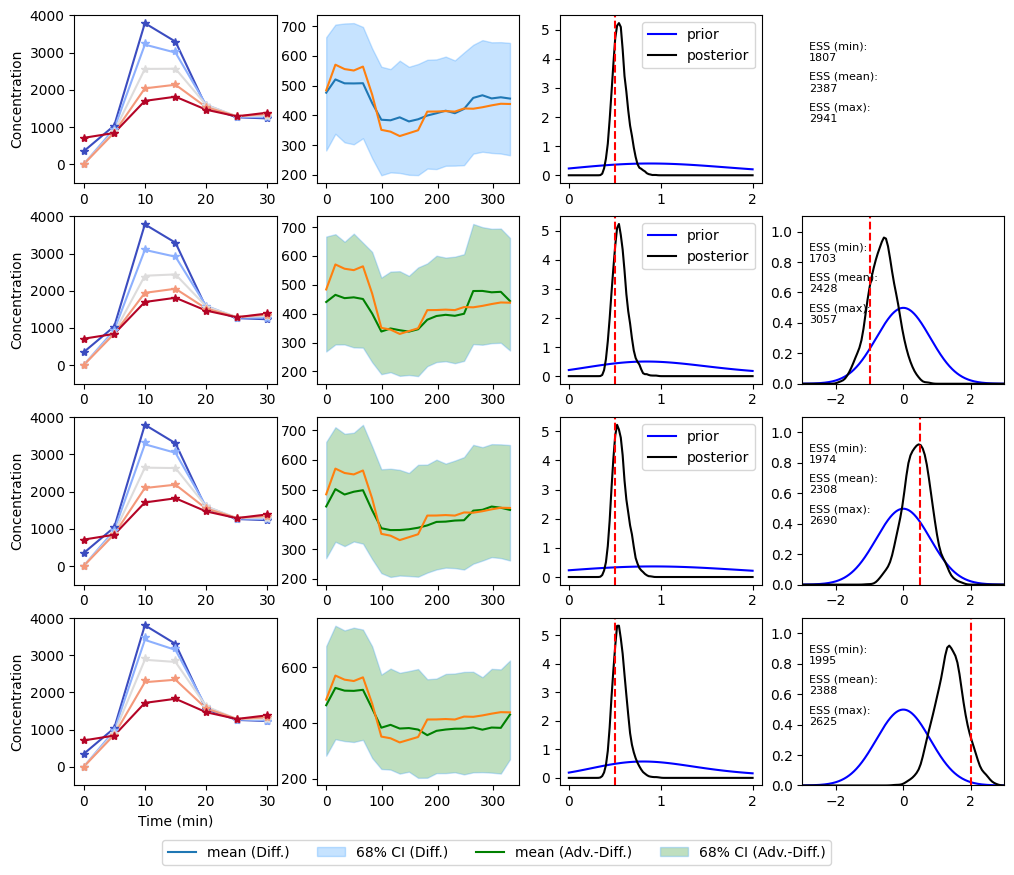

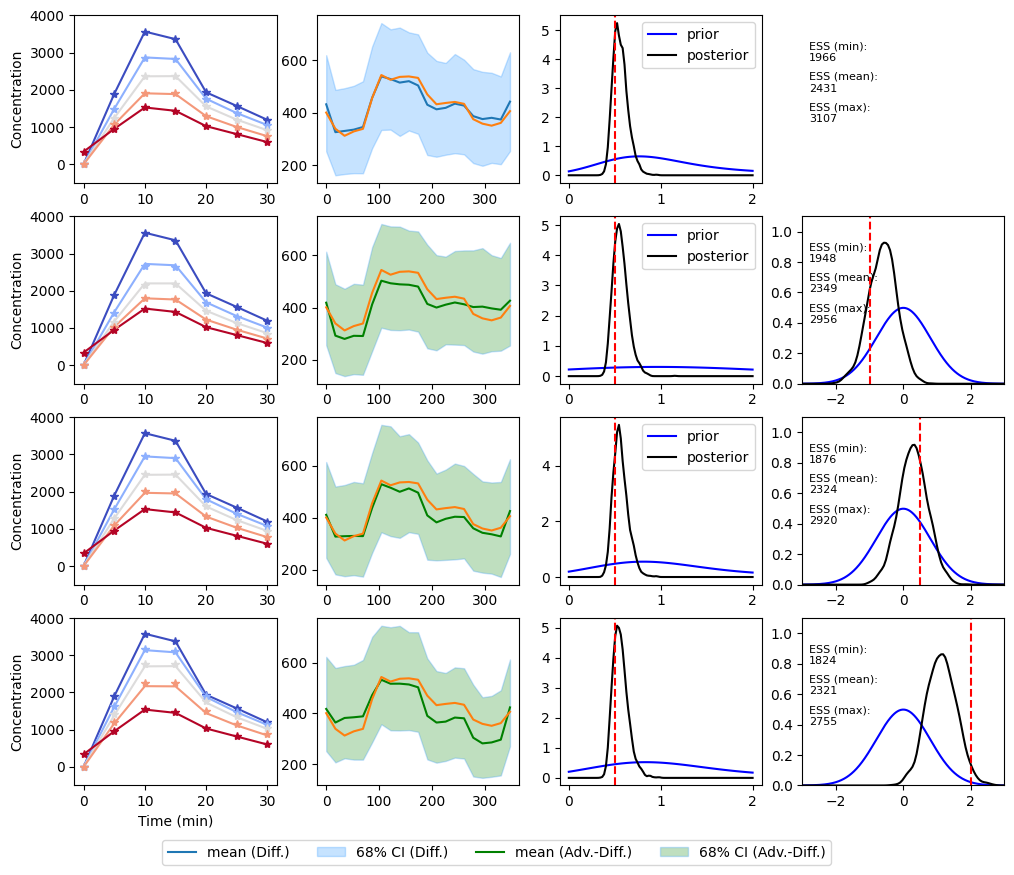

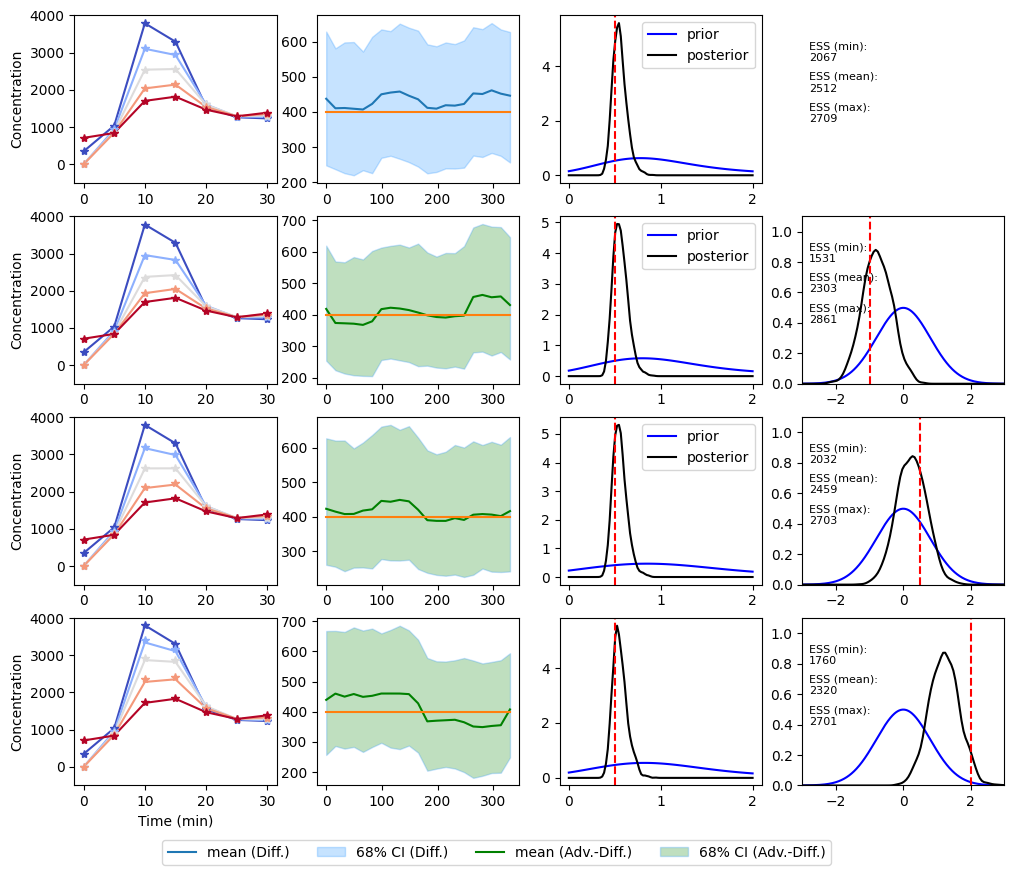

In [28]:
# create plots directory 
import os
if not os.path.exists('figures/control'):
    os.makedirs('figures/control')
color_map_string = 'coolwarm' #'twilight' #'terrain'#'coolwarm'#'berlin' #'brg'
colormap=plt.colormaps.get_cmap(color_map_string)

plot_type='over_time' # over_time or over_location
plot_control_case_v2(data_list_diff1, plot_type=plot_type, colormap=colormap)
plt.savefig('figures/control/control_diff1_v2_'+str(option)+'.png')

plot_control_case_v2(data_list_diff2, plot_type=plot_type, colormap=colormap)
plt.savefig('figures/control/control_diff2_v2_'+str(option)+'.png')

plot_control_case_v2(data_list_diff3, plot_type=plot_type, colormap=colormap)
plt.savefig('figures/control/control_diff3_v2_'+str(option)+'.png')
